In [1]:
!pip install pandas scikit-learn optuna statsmodels scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import optuna
import os
import logging
from include.utils import *

In [3]:
from skopt import *
from skopt.space import *
from sklearn.ensemble import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.tree import *

**1. Engenharia de Recursos**

Novos recursos derivados dos dados existentes

In [4]:
# Obtém a largura do terminal - uso mais embaixo nos prints
terminal_width = os.get_terminal_size().columns

# Carregar os dados processados
X_train = pd.read_csv('../planilhas/3_dados_processados_treino.csv', encoding='latin-1')
X_test = pd.read_csv('../planilhas/4_dados_processados_teste.csv', encoding='latin-1')
y_train = pd.read_csv('../planilhas/5_dados_processados_treino_target.csv', encoding='latin-1')
y_test = pd.read_csv('../planilhas/6_dados_processados_teste_target.csv', encoding='latin-1')

# Converter y_train em um array unidimensional
y_train = y_train.values.ravel()

# Converter y_test em um array unidimensional
y_test = y_test.values.ravel()

# Descarto na predição do modelo, mas trago novamente nos dados futuros
colunas_descartadas_treino = X_train[['Gênero','Região','Categoria_IMC']]
colunas_descartadas_teste = X_test[['Gênero','Região','Categoria_IMC']]
X_train = X_train.drop(colunas_descartadas_treino, axis=1)
X_test = X_test.drop(colunas_descartadas_teste, axis=1)

**2. Limpeza de Dados**

In [5]:
X_train = limpar_dados(X_train)
X_test = limpar_dados(X_test)

In [6]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_train.isnull().sum())
print(f"\nQuantidade de linhas: {X_train.shape[0]}. Quantidade de colunas: {X_train.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade      0
IMC        0
Filhos     0
Fumante    0
dtype: int64

Quantidade de linhas: 8007. Quantidade de colunas: 4


In [7]:
print("\nQuantidade de valores ausentes por coluna:\n\n", X_test.isnull().sum())
print(f"\nQuantidade de linhas: {X_test.shape[0]}. Quantidade de colunas: {X_test.shape[1]}")


Quantidade de valores ausentes por coluna:

 Idade      0
IMC        0
Filhos     0
Fumante    0
dtype: int64

Quantidade de linhas: 2002. Quantidade de colunas: 4


**3. Pré-processamento**

In [8]:
# Inicializar o StandardScaler, que é usado para padronizar os recursos
scaler = StandardScaler()

# Aplicar a transformação de padronização nos dados de treinamento e ajustar o scaler aos dados
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar a mesma transformação de padronização aos dados de teste
X_test_scaled = scaler.transform(X_test)

# Calcular a matriz de correlação dos dados de treinamento
correlation_matrix = X_train.corr()
print('Visualizar a matriz de correlação:')
print(correlation_matrix)

Visualizar a matriz de correlação:
            Idade       IMC    Filhos   Fumante
Idade    1.000000  0.009708 -0.028058 -0.007577
IMC      0.009708  1.000000  0.020289  0.001663
Filhos  -0.028058  0.020289  1.000000  0.015805
Fumante -0.007577  0.001663  0.015805  1.000000


**Validação estatística**

Utilizando métricas estatísticas para validar a eficácia do modelo (p-value, intervalos de confiança):            

In [9]:
#dados_aux = X_train.copy()

#dados_aux['Fumante'] = dados_aux['Fumante'].map({'sim': 1, 'não': 0})

# Adicione uma coluna de intercepto aos dados
#dados_aux['Intercepto'] = 1

# Dividindo os dados em variáveis independentes (X) e variável dependente (y)
#X = dados_aux[['Idade', 'Filhos', 'Fumante']]
#y = dados_aux['Encargos']

# Ajustando o modelo de regressão linear usando OLS (Ordinary Least Squares)
#modelo = sm.OLS(X_test, X_train).fit()

# Calculando os p-values dos coeficientes
#p_values = modelo.summary2().tables[1]['P>|t|']

# Calculando os intervalos de confiança dos coeficientes
#conf_intervals = modelo.conf_int()

# Imprima os resultados
#print("P-values dos coeficientes:")
#print(p_values)
#print("\nIntervalos de Confiança dos coeficientes:")
#print(round(conf_intervals,2))

**4. Treinamento do Modelo**

In [10]:
# Adicionando mais modelos ao dicionário de modelos
models = {
    'Random Forest Regressor': RandomForestRegressor(),
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Lasso Regression': Lasso()
}

param_spaces = {
    'Random Forest Regressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': list(range(1, 11)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Support Vector Regression': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear']
    },
    'Decision Tree Regressor': {
        'max_depth': list(range(1, 11)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'K-Nearest Neighbors Regressor': {
        'n_neighbors': list(range(3, 11)),
        'weights': ['uniform', 'distance']
    },
    'Gradient Boosting Regressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': list(range(1, 11)),
        'learning_rate': [0.05, 0.1, 0.2]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10],
        'selection': ['cyclic', 'random']
    },
    'Linear Regression': {
        'fit_intercept': [True, False],
        'copy_X': [True, False],
        'n_jobs': [-1]  # Se quiser paralelizar o processo de ajuste
    }
}

In [11]:
# usado no método abaixo BayesSearchCV (como demora um pouco, caso seja necessário, basta reduzir a quantidade de interações
numero_interacoes_bayes_search = 1

# Treinamento e avaliação dos modelos com BayesSearchCV
for name, model in models.items():
    # Imprime uma linha separadora com base na largura do terminal
    print('-' * terminal_width)
    print(f"Modelo {name}:");
    
    try:
        verificar_se_modelo_tem_dados_nan_inf(model, X_train, y_train)
        print(f"\nSem NaN e Inf nas previsões do modelo")
    except ValueError as e:
        print(f"{name}: {e}")
    
    if name in param_spaces:
        bayes_search = BayesSearchCV(model, param_spaces[name], cv=5, scoring='neg_mean_squared_error', n_iter=numero_interacoes_bayes_search, random_state=42)
        bayes_search.fit(X_train, y_train)
        model = bayes_search.best_estimator_
        print(f"\nMelhores parâmetros: {bayes_search.best_params_}")
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r_quadrado = r2_score(y_test, y_pred)

    print(f'\nErro Médio Quadrático (MSE): {round(mse,2)}')
    # Calcular acurácia média usando validação cruzada
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f'\nErro Absoluto Médio (MAE): {round(mae.mean(),2)}')
    print(f'\nCoeficiente de determinação (R2): {round(r_quadrado.mean(),2)}')
    print(f'\nAcurácia média com validação cruzada: {round(scores.mean(),2)}')
        
    # Calcula e exibe a importância das características para o modelo atual
    if hasattr(model, 'feature_importances_'):
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': model.feature_importances_})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"\nImportância das características:")
        print(f'\n{round(importance_df,2)}')
    elif isinstance(model, LinearRegression) or isinstance(model, Lasso):        
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Coeficiente': model.coef_})
        importance_df = importance_df.sort_values(by='Coeficiente', ascending=False)
        print(f"\nCoeficientes das características:")
        print(f'\n{round(importance_df,2)}')
    elif isinstance(model, SVR):
        support_indices = model.support_
        support_features = X_train.iloc[support_indices]
        feature_importance_svr = support_features.mean(axis=0)
        importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importance_svr})
        importance_df = importance_df.sort_values(by='Importância', ascending=False)
        print(f"\nImportância das características:")
        print(f'\n{round(importance_df,2)}')
    else:
        print("\nNão é possível calcular a importância das características")

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Random Forest Regressor:

Sem NaN e Inf nas previsões do modelo

Melhores parâmetros: OrderedDict({'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300})

Erro Médio Quadrático (MSE): 641126.25

Erro Absoluto Médio (MAE): 333.47

Coeficiente de determinação (R2): 0.74

Acurácia média com validação cruzada: 0.7

Importância das características:

   Colunas  Importância
0    Idade         0.84
2   Filhos         0.11
1      IMC         0.03
3  Fumante         0.02
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Modelo Linear Regression:

Sem NaN e Inf nas previsões do modelo

Melhores parâmetros: OrderedDi

**5. Comparação de Modelos**

In [12]:
# Seleção de modelo com base na maior pontuação de validação cruzada
best_model_name = max(models, key=lambda model: cross_val_score(models[model], X_train, y_train, cv=5).mean())

**6. Seleção de Modelo**

In [13]:
best_model = models[best_model_name]
print(f'Melhor modelo: {best_model_name}')

Melhor modelo: Linear Regression


**7. Otimização de Modelo**

In [14]:
numero_tentativas_optuna = 50

def create_model(trial):
    if best_model_name == 'Random Forest Regressor':
        n_estimators = trial.suggest_categorical('n_estimators', param_spaces[best_model_name]['n_estimators'])
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        min_samples_split = trial.suggest_categorical('min_samples_split', param_spaces[best_model_name]['min_samples_split'])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', param_spaces[best_model_name]['min_samples_leaf'])
        max_features = trial.suggest_categorical('max_features', param_spaces[best_model_name]['max_features'])
        model = RandomForestRegressor(n_estimators=n_estimators, 
                                       max_depth=max_depth, 
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features)
    elif best_model_name == 'Decision Tree Regressor':
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        min_samples_split = trial.suggest_categorical('min_samples_split', param_spaces[best_model_name]['min_samples_split'])
        min_samples_leaf = trial.suggest_categorical('min_samples_leaf', param_spaces[best_model_name]['min_samples_leaf'])
        model = DecisionTreeRegressor(max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf)
    elif best_model_name == 'Support Vector Regression':
        C = trial.suggest_categorical('C', param_spaces[best_model_name]['C'])
        gamma = trial.suggest_categorical('gamma', param_spaces[best_model_name]['gamma'])
        kernel = trial.suggest_categorical('kernel', param_spaces[best_model_name]['kernel'])
        model = SVR(C=C, gamma=gamma, kernel=kernel)
    elif best_model_name == 'Linear Regression':
        fit_intercept = trial.suggest_categorical('fit_intercept', param_spaces[best_model_name]['fit_intercept'])
        copy_X = trial.suggest_categorical('copy_X', param_spaces[best_model_name]['copy_X'])
        n_jobs = trial.suggest_categorical('n_jobs', param_spaces[best_model_name]['n_jobs'])
        model = LinearRegression(fit_intercept=fit_intercept, copy_X=copy_X, n_jobs=n_jobs)
    elif best_model_name == 'K-Nearest Neighbors Regressor':
        n_neighbors = trial.suggest_categorical('n_neighbors', param_spaces[best_model_name]['n_neighbors'])
        weights = trial.suggest_categorical('weights', param_spaces[best_model_name]['weights'])
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    elif best_model_name == 'Gradient Boosting Regressor':
        n_estimators = trial.suggest_categorical('n_estimators', param_spaces[best_model_name]['n_estimators'])
        max_depth = trial.suggest_categorical('max_depth', param_spaces[best_model_name]['max_depth'])
        learning_rate = trial.suggest_categorical('learning_rate', param_spaces[best_model_name]['learning_rate'])
        model = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    elif best_model_name == 'Lasso Regression':
        alpha = trial.suggest_categorical('alpha', param_spaces[best_model_name]['alpha'])
        selection = trial.suggest_categorical('selection', param_spaces[best_model_name]['selection'])
        model = Lasso(alpha=alpha, selection=selection)
    else:
        model = models[best_model_name]  # Usar os hiperparâmetros padrão para outros modelos
    return model

# Função para otimização de hiperparâmetros
def objective(trial):
    # Criar uma nova instância do modelo com hiperparâmetros definidos pelo Optuna
    model = create_model(trial)
    
    # Avaliação do modelo utilizando validação cruzada
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring='neg_mean_squared_error').mean()
    return score

# Criar o objeto de estudo Optuna
study = optuna.create_study(direction='minimize')

# Realizar a otimização dos hiperparâmetros
study.optimize(objective, n_trials=numero_tentativas_optuna)

[I 2024-04-16 17:48:40,549] A new study created in memory with name: no-name-cd832041-6ea0-4ee9-bd89-13777f07e83a
[I 2024-04-16 17:48:43,802] Trial 0 finished with value: -912014.6324595382 and parameters: {'fit_intercept': False, 'copy_X': False, 'n_jobs': -1}. Best is trial 0 with value: -912014.6324595382.
[I 2024-04-16 17:48:46,732] Trial 1 finished with value: -912014.6324595382 and parameters: {'fit_intercept': False, 'copy_X': False, 'n_jobs': -1}. Best is trial 0 with value: -912014.6324595382.
[I 2024-04-16 17:48:50,329] Trial 2 finished with value: -912014.6324595382 and parameters: {'fit_intercept': False, 'copy_X': True, 'n_jobs': -1}. Best is trial 0 with value: -912014.6324595382.
[I 2024-04-16 17:48:50,403] Trial 3 finished with value: -848559.9381118192 and parameters: {'fit_intercept': True, 'copy_X': True, 'n_jobs': -1}. Best is trial 0 with value: -912014.6324595382.
[I 2024-04-16 17:48:50,463] Trial 4 finished with value: -912014.6324595382 and parameters: {'fit_int

In [15]:
# Obtenha os melhores parâmetros do estudo Optuna
best_params = study.best_params
best_score = study.best_value

# Configure o modelo com os melhores parâmetros
best_model.set_params(**best_params)

# Ajuste o modelo aos dados de treinamento
best_model.fit(X_train, y_train)

# Avaliação do modelo
score_train = model.score(X_train, y_train)
score_test = model.score(X_test, y_test)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_quadrado = r2_score(y_test, y_pred)

# Imprimir resultados
print(f"\nModelo:", best_model_name)
print("\nMelhores parâmetros:", best_params)
print("\nMelhor score:", round(best_score,2))
print(f"\nScore treino: {round(score_train,2)}")
print(f"\nScore teste: {round(score_test,2)}")
print(f'\nErro Médio Quadrático (MSE): {round(mse,2)}')
print(f'\nErro Absoluto Médio (MAE): {round(mae.mean(),2)}')
print(f'\nCoeficiente de determinação (R2): {round(r_quadrado.mean(),2)}')


Modelo: Linear Regression

Melhores parâmetros: {'fit_intercept': False, 'copy_X': False, 'n_jobs': -1}

Melhor score: -912014.63

Score treino: 0.66

Score teste: 0.74

Erro Médio Quadrático (MSE): 699708.58

Erro Absoluto Médio (MAE): 349.17

Coeficiente de determinação (R2): 0.72


In [16]:
# Obter a importância das características apenas para modelos que suportam esse atributo
if hasattr(best_model, 'feature_importances_'):
    # Obter a importância das características do modelo
    feature_importances = best_model.feature_importances_
    
    # Criar um DataFrame para visualizar a importância das características
    importance_df = pd.DataFrame({'Colunas': X_train.columns, 'Importância': feature_importances})

    # Ordenar as características por importância
    importance_df = importance_df.sort_values(by='Importância', ascending=False)
    
    print("\nQuais características individuais têm maior impacto nos custos médicos cobrados pelo seguro de saúde?")
    print(round(importance_df,2))

    # Selecionar as características mais importantes (por exemplo, as 10 mais importantes)
    top_features = importance_df.head(10)['Colunas'].tolist()  # Ajuste o número conforme necessário
    
    # Calcular a matriz de correlação apenas para as características mais importantes
    correlation_matrix = X_train[top_features].corr()
    
    # Visualizar a matriz de correlação
    print("\nExiste alguma correlação entre certas características (por exemplo, idade, IMC) e os custos médicos?")
    print(correlation_matrix)
else:
    print("O modelo selecionado não suporta o cálculo de importância das características.")

O modelo selecionado não suporta o cálculo de importância das características.


In [17]:
# Validação cruzada para detecção de overfitting
def overfitting_detection(model, X, y, cv=5):
    train_mse = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error').mean()
    model.fit(X, y)
    y_pred_train = model.predict(X)
    test_mse = np.mean((y - y_pred_train) ** 2)
    return train_mse, test_mse

# Exemplo de uso
train_mse, test_mse = overfitting_detection(best_model, X_train_scaled, y_train)

print("Erro Médio Quadrático (MSE) no conjunto de treinamento:", round(train_mse,2))
print("Erro Médio Quadrático (MSE) no conjunto de teste:", round(test_mse,2))

Erro Médio Quadrático (MSE) no conjunto de treinamento: 25167406.63
Erro Médio Quadrático (MSE) no conjunto de teste: 25142387.59


**8. Entrega dos dados futuros**

In [18]:
# Definição de dados futuros - 200 linhas
dados_futuros = pd.DataFrame(np.random.rand(200, len(X_test.columns)), columns=X_test.columns)
print(dados_futuros.head())

      Idade       IMC    Filhos   Fumante
0  0.178315  0.756288  0.123207  0.652531
1  0.846007  0.711795  0.188073  0.278493
2  0.384009  0.648187  0.616330  0.003780
3  0.521018  0.357485  0.641336  0.442236
4  0.809473  0.708760  0.043813  0.841794


Modelo treinado para fazer previsões dos encargos futuros:

In [19]:
encargos_futuros = prever_encargos_futuros(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Grupos de indivíduos com diferentes níveis de risco

In [20]:
grupos_risco = segmentacao_de_risco(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Análises de sensibilidade para entender o impacto das mudanças nas características dos segurados nos encargos previstos:

In [21]:
encargos_futuros_expectativa_40_anos = analise_de_sensibilidade(best_model, dados_futuros, 'Idade', novo_valor=40)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Utilizando as previsões dos encargos para otimizar a alocação de recursos:

In [22]:
recursos_otimizados = otimizacao_de_recursos(encargos_futuros)

Utilizando as informações obtidas com o modelo para desenvolver planos estratégicos:

In [23]:
planos_estrategicos = planejamento_estrategico(best_model, dados_futuros)

C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\luiz.santos\Documents\FIAP Grupo\Tech Challenge\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [24]:
# Inserir as colunas descartadas em X_test
for coluna in colunas_descartadas_treino.columns:
    dados_futuros.insert(loc=len(dados_futuros.columns), column=coluna, value=colunas_descartadas_treino[coluna])

# Adicionando as novas colunas na planilha dados futuros
dados_futuros['Encargos Reais'] = np.nan # não consegui ainda obter (dúvida com o professor)
dados_futuros['Encargo Futuro'] = encargos_futuros
dados_futuros['Grupos Risco'] = grupos_risco
dados_futuros['Encargo Futuro - Expectativa 40 anos'] = encargos_futuros_expectativa_40_anos
dados_futuros['Otimização Recursos'] = recursos_otimizados
dados_futuros['Planos estratégicos'] = planos_estrategicos

# Salvar os dados randômicos futuros
dados_futuros.to_csv("../planilhas/8_dados_futuros.csv", index=False, encoding='latin1')

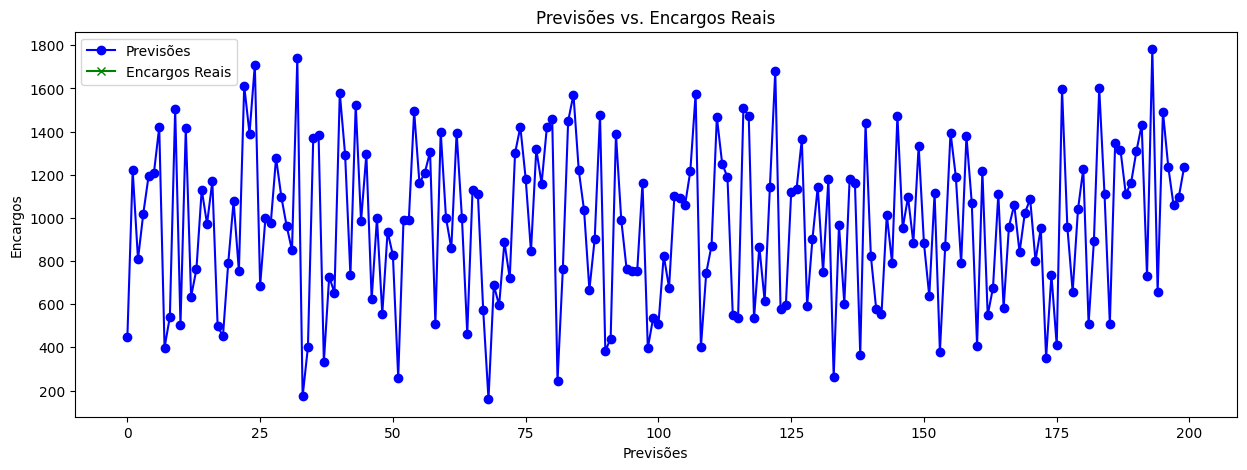

In [25]:
fig, axs = plt.subplots(figsize=(15, 5))

plt.plot(dados_futuros['Encargo Futuro'], label='Previsões', color='blue', marker='o')
plt.plot(dados_futuros['Encargos Reais'], label='Encargos Reais', color='green', marker='x')

plt.xlabel('Previsões')
plt.ylabel('Encargos')
plt.legend()
plt.title('Previsões vs. Encargos Reais')
plt.show()